# Generate Pitch Outcome
 - Given the thrown pitch into the batter, will a ball, strike, or contact be made?
 - This is the first portion of the batting outcome
 - Splitting batting outcome into two parts, (second being if contact is made, what happens?) makes things more clear
 - Will be used as input to the second part of the batter outcome mentioned above

## Potential Difficulties:
 - How to factor in umpire for discrepencies in strikes/balls?
## TODO:
 - Hyperparameter optimization
 - Compare with bayesian models
 - Figure out how to solve small sample..

In [4]:
import torch
import torch.nn as nn
import torch.optim
from tqdm import trange

#get test set
from src.features import build_features as f
train_set, val_set, num_classes, num_features, encoder = f.get_pitch_outcome_dataset(665489)

2024-05-03 13:25:41,402 - src.features.build_features - INFO - Loading dataset for 665489
2024-05-03 13:25:43,689 - src.features.build_features - INFO - Data successfully queried/transformed for 665489


In [116]:
class PitchOutcome(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PitchOutcome, self).__init__()
        self.l1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

In [117]:
num_epochs = 200

input_size = num_features
num_classes = num_classes

model = PitchOutcome(input_size, num_classes)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

val_accuracies, val_losses, train_losses = [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
model.to(device)

for epoch in (t := trange(num_epochs)):

    #train model
    model.train()
    running_loss = 0    
    for features, labels in train_set:

        features, labels = features.to(device), labels.to(device)
        
        #zero grads
        optim.zero_grad()
        #forward + backward + optimize
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()
        #track loss
        running_loss += loss.item()
    
    running_loss /= len(train_set)
    train_losses.append(running_loss)


    #validate model
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_set:

            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #convert one hot back to label
            labels = torch.argmax(labels, dim=1)
            #print(predicted.shape, labels.shape, labels)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_set)
    val_losses.append(val_loss)
    val_accuracies.append(100 * correct//total)
    
    t.set_description(f'loss: {running_loss:.4f} accuracy: {100 * correct//total}%')

loss: 0.7081 accuracy: 64%: 100%|███████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02it/s]


In [205]:
def pitch_outcome_loglik(model, train_set, val_set):

    train_true_labels = []
    predicted_probs = []
    true_labels = []
    
    # Set model to evaluation mode
    model.to('cpu')
    model.eval()
    
    # Get predicted probabilities and true labels
    with torch.no_grad():
        for features, labels in val_set:
            features, labels = features, labels
            outputs = model(features)
            predicted_probs.extend(torch.softmax(outputs, dim=1).numpy())  # Convert to probabilities
            true_labels.extend(labels.numpy())
            train_true_labels.extend(labels.numpy())

    # Convert lists to numpy arrays
    predicted_probs = np.array(predicted_probs)
    log_predicted_probs = np.log(predicted_probs)
    true_labels = np.array(true_labels)
    train_true_labels = np.array(train_true_labels)
    
    #compute loglik for model
    true_class_indices = np.argmax(true_labels, axis=1)
    log_liks = log_predicted_probs[np.arange(len(true_class_indices)), true_class_indices]
    total_log_lik = np.sum(log_liks)

    #------------- val loglik is better than multinomail ----------
    #compute loglik for multinomial model
    
    #computes proportion of times a certain value showed up
    categorical_p_est = np.mean(train_true_labels, axis=0)
    log_predicted_probs = np.log(categorical_p_est)
    categorical_dist_logliks = log_predicted_probs[true_class_indices]
    categorical_log_lik = np.sum(categorical_dist_logliks)

    print(f'ML Pitch Outcome Model LogLik: {total_log_lik:.2f}\nStandard Categorical Distribution LogLik: {categorical_log_lik:.2f}')

    assert(total_log_lik > categorical_log_lik)
    
    return total_log_lik, categorical_log_lik


pitch_outcome_loglik(model, train_set, val_set)

ML Pitch Outcome Model LogLik: -2264.49
Standard Categorical Distribution LogLik: -2987.19


(-2264.487, -2987.1938)

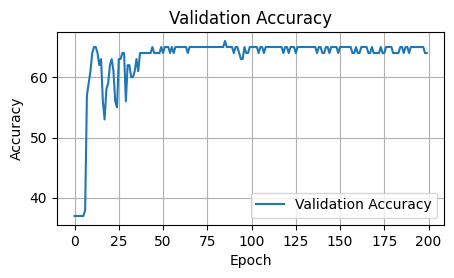

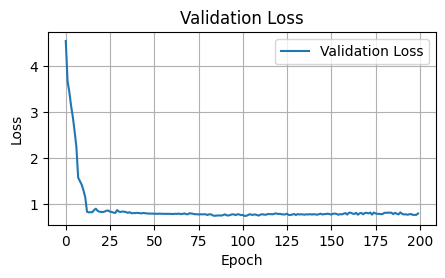

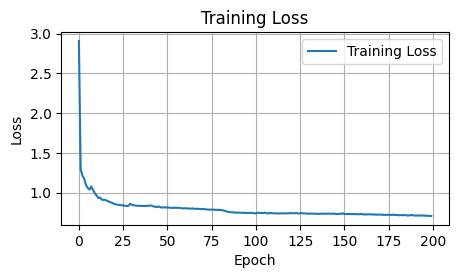

In [119]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(5, 2.5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation losses
plt.figure(figsize=(5, 2.5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training losses
plt.figure(figsize=(5, 2.5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

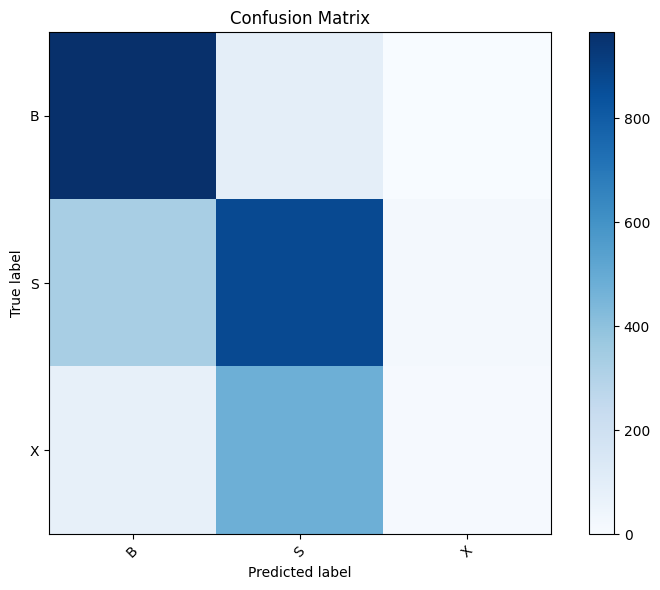

In [120]:
model.to('cpu')
model.eval()
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for features, labels in val_set:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        pred_labels = torch.zeros_like(outputs)
        pred_labels.scatter_(1, predicted.unsqueeze(1), 1)

        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Decode one-hot encoded true labels
true_labels_decoded = encoder['type'].inverse_transform(true_labels)

# Decode predicted labels
predicted_labels_decoded = encoder['type'].inverse_transform(pred_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels_decoded, predicted_labels_decoded)


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
classes = encoder['type'].categories_[0]
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.tight_layout()
plt.show()